In [1]:

!pip install --only-binary=:all: numpy==1.24.3
!pip install --only-binary=:all: pandas scipy scikit-learn
!pip install --only-binary=:all: matplotlib seaborn
!pip install --only-binary=:all: lightgbm xgboost catboost
!pip install --only-binary=:all: imbalanced-learn optuna

ERROR: Could not find a version that satisfies the requirement numpy==1.24.3 (from versions: 1.26.0, 1.26.1, 1.26.2, 1.26.3, 1.26.4, 2.0.0, 2.0.1, 2.0.2, 2.1.0rc1, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.2.0rc1, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5)
ERROR: No matching distribution found for numpy==1.24.3


In [ ]:
import numpy as np
import pandas as pd
import time
import optuna
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                            precision_recall_curve, average_precision_score,
                            precision_score, recall_score, f1_score, confusion_matrix)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from IPython.display import display, HTML

In [ ]:

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
start_time = time.time()

In [ ]:

file_path = "/Users/pratyushmalviya/Desktop/working models final/tuneable1 no visuals/creditcard.csv"
df = pd.read_csv(file_path)



Exploratory data analysis-
performing  a basic exploratory analysis on the dataframe , particularly focusing on class distribution.

=== EXPLORATORY DATA ANALYSIS ===
Dataset shape: (284807, 31)
Missing values: 0


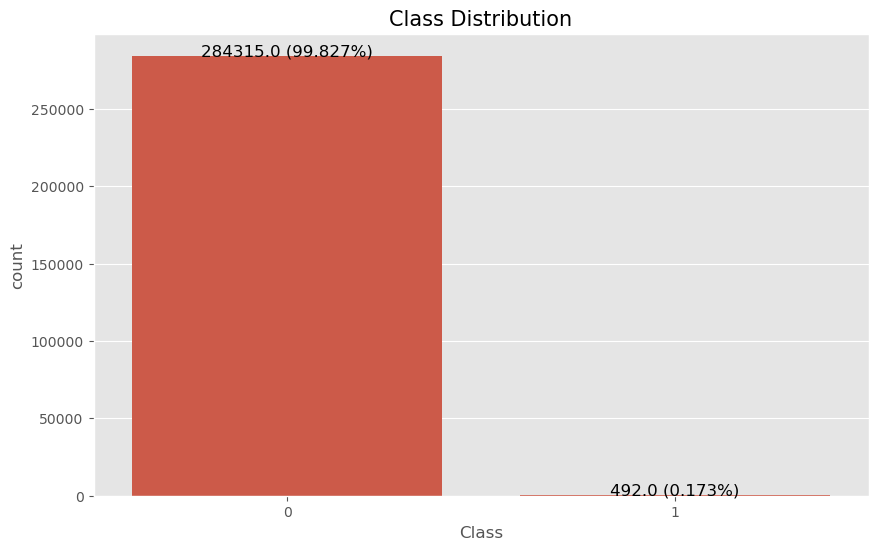

In [ ]:
print("=== EXPLORATORY DATA ANALYSIS ===")

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Class', data=df)
plt.title("Class Distribution", fontsize=15)
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.1,
            f'{height} ({height/total*100:.3f}%)',
            ha="center", fontsize=12)

plt.show()


Time feature analysis - 
To identify hourly patterns in fraudulent behavior, which can inform feature engineering

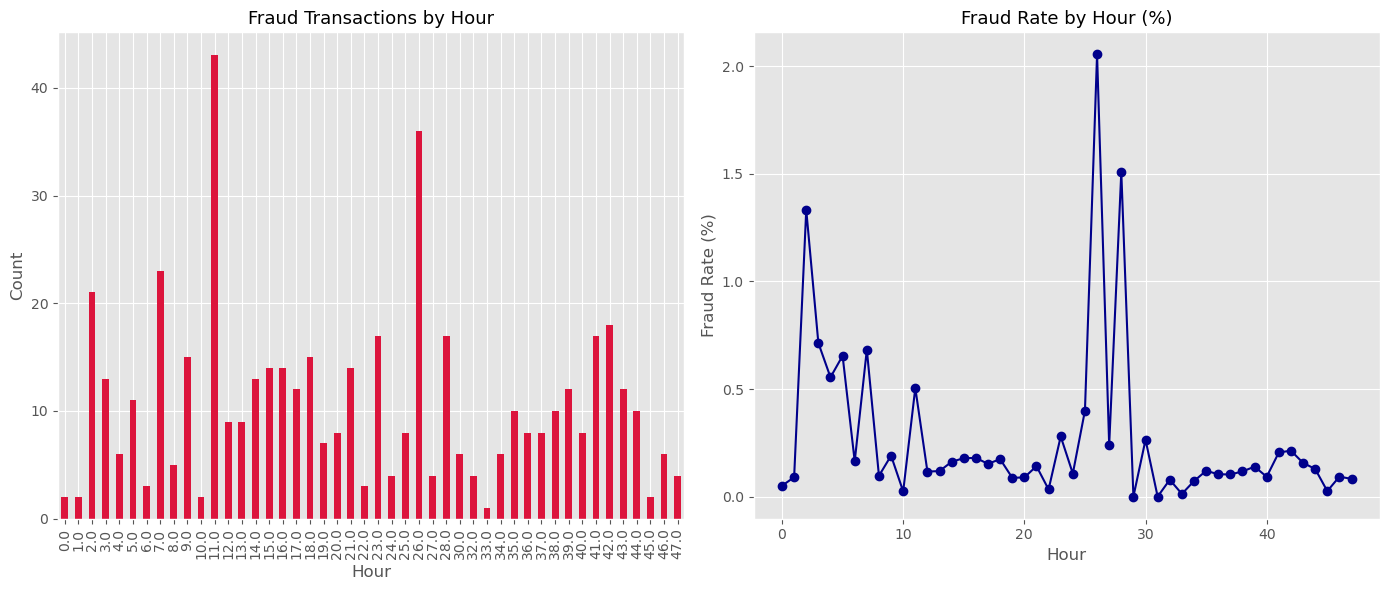

In [ ]:

if 'Time' in df.columns:
    plt.figure(figsize=(14, 6))
    
    
    df['Hour'] = df['Time'] // 3600
    plt.subplot(1, 2, 1)
    fraud_by_hour = df[df['Class'] == 1].groupby('Hour').size()
    fraud_by_hour.plot(kind='bar', color='crimson')
    plt.title('Fraud Transactions by Hour', fontsize=13)
    plt.xlabel('Hour')
    plt.ylabel('Count')
   
    plt.subplot(1, 2, 2)
    hourly_fraud_rate = df.groupby('Hour')['Class'].mean() * 100
    hourly_fraud_rate.plot(kind='line', marker='o', color='darkblue')
    plt.title('Fraud Rate by Hour (%)', fontsize=13)
    plt.xlabel('Hour')
    plt.ylabel('Fraud Rate (%)')
    
    plt.tight_layout()
    plt.show()


Transaction Amount Distribution Analysis -
To compare amount behavior between fraud and non-fraud transactions and creation of boxplot showing the median, IQR, and outliers of transaction amounts for each class.

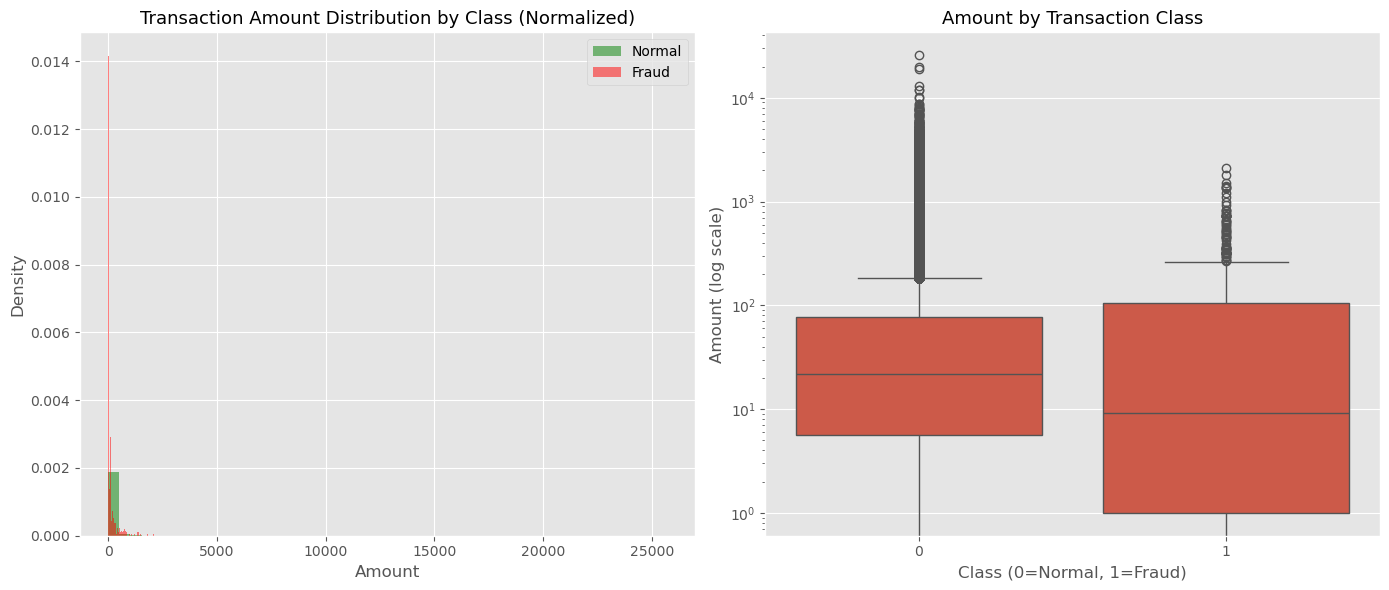

In [ ]:

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df[df['Class'] == 0]['Amount'].plot(kind='hist', bins=50, density=True, alpha=0.5, label='Normal', color='green')
df[df['Class'] == 1]['Amount'].plot(kind='hist', bins=50, density=True, alpha=0.5, label='Fraud', color='red')
plt.title('Transaction Amount Distribution by Class (Normalized)', fontsize=13)
plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Amount by Transaction Class', fontsize=13)
plt.yscale('log')
plt.xlabel('Class (0=Normal, 1=Fraud)')
plt.ylabel('Amount (log scale)')

plt.tight_layout()
plt.show()

 Correlation Matrix of Anonymous Features-
 To understand how the anonymized features are related to each other, which helps

1) Detect multicollinearity.
2) Guide dimensionality reduction or feature selection.

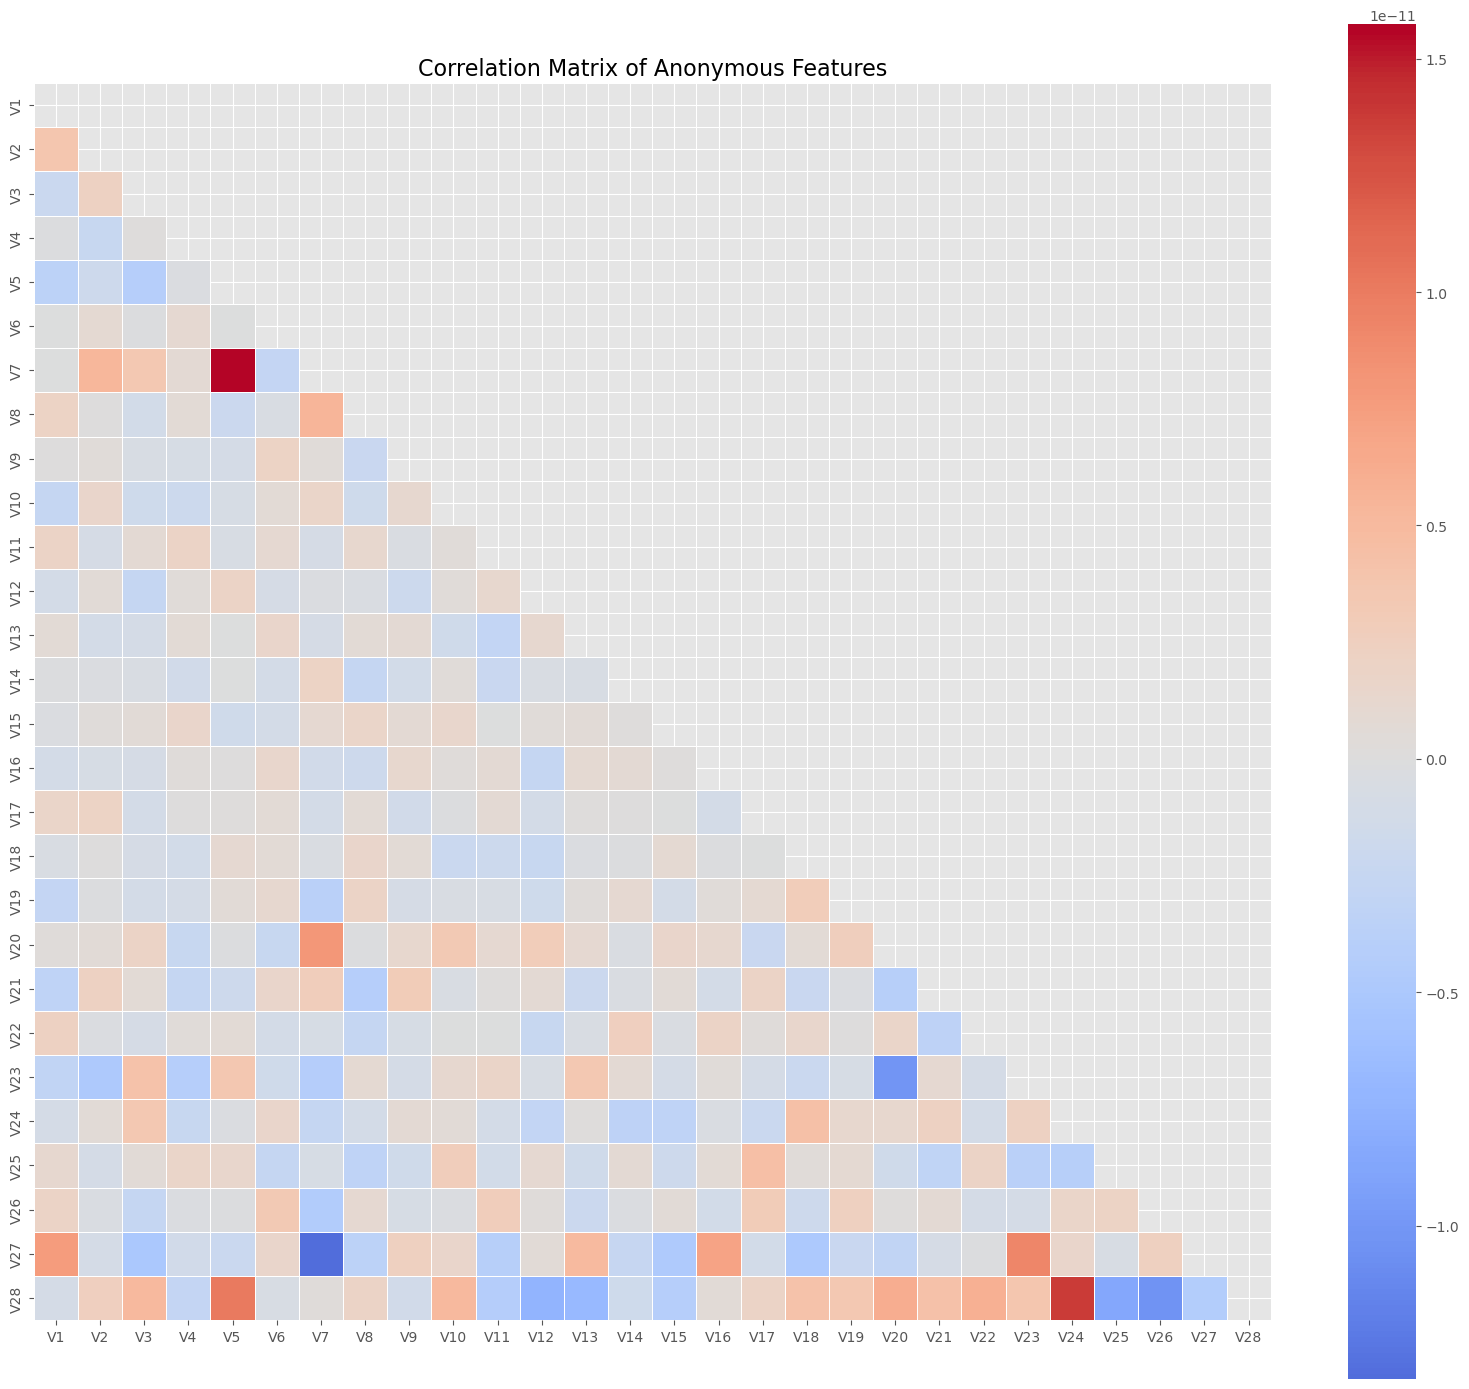

In [ ]:

plt.figure(figsize=(16, 14))
v_columns = [col for col in df.columns if col.startswith('V')]
corr = df[v_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, 
            square=True, linewidths=.5, annot=False)
plt.title('Correlation Matrix of Anonymous Features', fontsize=16)
plt.tight_layout()
plt.show()

A Custom Feature Engineering Transformer-
This class defines a custom scikit-learn-compatible transformer for enriching a credit card fraud dataset by creating time-based, amount-based, and anonymized (V) feature-based features.

Converts 'Time' to Hour_sin, Hour_cos

Adds time-of-day flags: IsMorning, IsAfternoon, IsEvening, IsNight

Creates Amount_Log (log scale of amount)

Creates Amount_Zscore (normalized amount)

Categorizes amounts: IsSmallTxn, IsMediumTxn, IsLargeTxn

Aggregates V features: V_Sum, V_Mean, V_Std, V_Kurtosis, V_Skew

Generates ratios: V1_to_V3, V4_to_V10, V11_to_V4

Drops original Time, Hour, and Amount columns

In [ ]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Custom transformer to create new features"""
    
    def __init__(self):
        self.mean_amount = None
        self.std_amount = None
    
    def fit(self, X, y=None):
        if 'Amount' in X.columns:
            self.mean_amount = X['Amount'].mean()
            self.std_amount = X['Amount'].std()
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        
        if 'Time' in X_new.columns:
            X_new['Hour'] = X_new['Time'] // 3600 % 24
            X_new['Hour_sin'] = np.sin(2 * np.pi * X_new['Hour'] / 24)
            X_new['Hour_cos'] = np.cos(2 * np.pi * X_new['Hour'] / 24)

            X_new['IsMorning'] = ((X_new['Hour'] >= 6) & (X_new['Hour'] < 12)).astype(int)
            X_new['IsAfternoon'] = ((X_new['Hour'] >= 12) & (X_new['Hour'] < 18)).astype(int)
            X_new['IsEvening'] = ((X_new['Hour'] >= 18) & (X_new['Hour'] < 22)).astype(int)
            X_new['IsNight'] = ((X_new['Hour'] >= 22) | (X_new['Hour'] < 6)).astype(int)
            
            X_new = X_new.drop(['Time', 'Hour'], axis=1)

        if 'Amount' in X_new.columns:
            X_new['Amount_Log'] = np.log1p(X_new['Amount'])
            X_new['Amount_Zscore'] = (X_new['Amount'] - self.mean_amount) / self.std_amount
    
            X_new['IsSmallTxn'] = (X_new['Amount'] <= 5).astype(int)
            X_new['IsMediumTxn'] = ((X_new['Amount'] > 5) & (X_new['Amount'] <= 100)).astype(int)
            X_new['IsLargeTxn'] = (X_new['Amount'] > 100).astype(int)
            
            X_new = X_new.drop(['Amount'], axis=1)
        
        #  features engineering
        
        v_columns = [col for col in X_new.columns if col.startswith('V')]
        if v_columns:
            
            X_new['V_Sum'] = X_new[v_columns].sum(axis=1)
            X_new['V_Mean'] = X_new[v_columns].mean(axis=1)
            X_new['V_Std'] = X_new[v_columns].std(axis=1)
            X_new['V_Kurtosis'] = X_new[v_columns].kurtosis(axis=1)
            X_new['V_Skew'] = X_new[v_columns].skew(axis=1)
            
            if all(col in X_new.columns for col in ['V1', 'V3', 'V4', 'V10', 'V11']):
                X_new['V1_to_V3'] = X_new['V1'] / (X_new['V3'] + 1e-8)
                X_new['V4_to_V10'] = X_new['V4'] / (X_new['V10'] + 1e-8)
                X_new['V11_to_V4'] = X_new['V11'] / (X_new['V4'] + 1e-8)
        
        return X_new


enhanced dataframe-

Applies the FeatureEngineer transformer to create new features, enhancing the dataset (df_enhanced).

Computes and visualizes the top 20 features with the strongest absolute correlations to the target variable 'Class' using a bar chart.


=== APPLYING FEATURE ENGINEERING ===


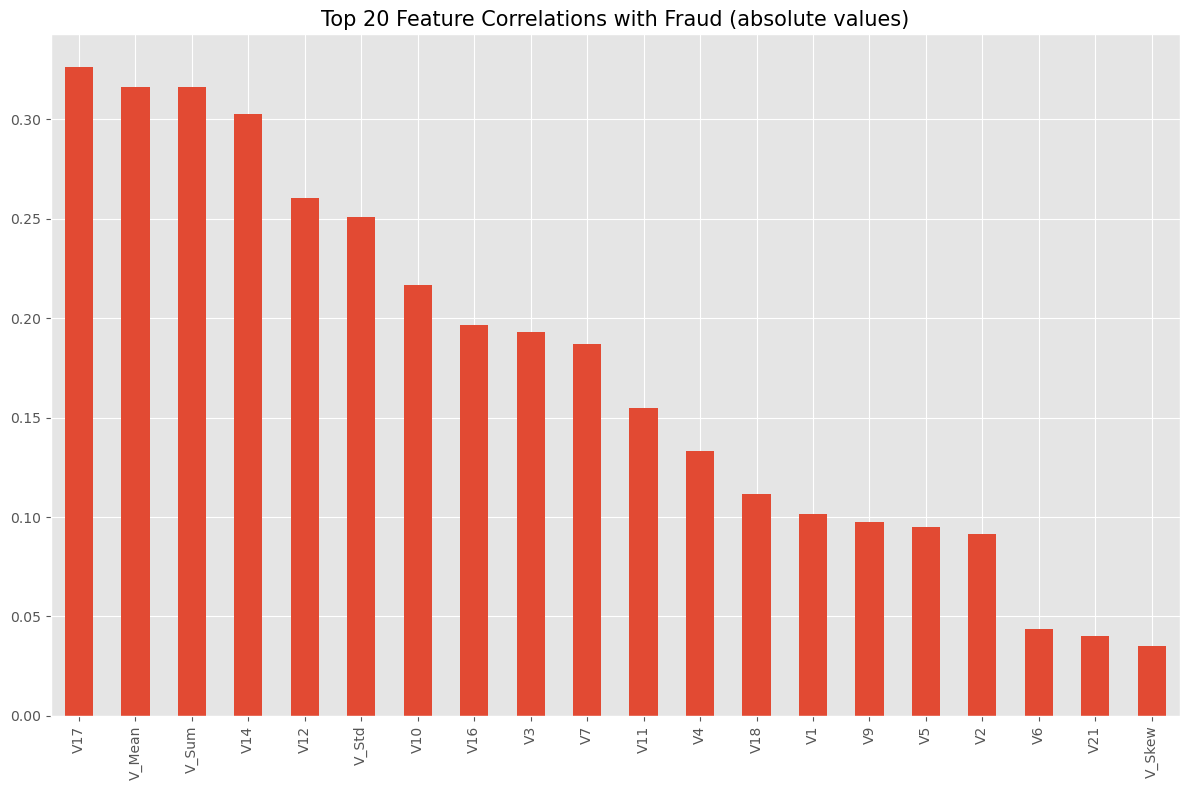

In [ ]:

print("\n=== APPLYING FEATURE ENGINEERING ===")
feature_engineer = FeatureEngineer()
df_enhanced = feature_engineer.fit_transform(df)

if 'Class' in df_enhanced.columns:
    correlations = df_enhanced.corrwith(df_enhanced['Class']).sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    correlations.drop('Class').abs().sort_values(ascending=False).head(20).plot(kind='bar')
    plt.title('Top 20 Feature Correlations with Fraud (absolute values)', fontsize=15)
    plt.tight_layout()
    plt.show()


 DATA PREPARATION AND PREPROCESSING

In [ ]:
# Split into features and target
X = df_enhanced.drop(['Class'], axis=1) if 'Class' in df_enhanced.columns else df_enhanced
y = df['Class'] if 'Class' in df else None

print(f"\nFeatures shape after engineering: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Features shape after engineering: (284807, 47)
Training set: (199364, 47), Test set: (85443, 47)


Define preprocessing pipeline with caching

In [ ]:
from tempfile import mkdtemp
from joblib import Memory
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=0)


Preprocessing Pipeline: Applies PowerTransformer (Yeo-Johnson method) to scale the training and test data (X_train, X_test).

PCA Transformation: Reduces dimensionality using PCA to retain 95% variance, creating new PCA features.

Combined Features: Combines the original preprocessed features with the PCA components, resulting in a new feature set.

In [ ]:
# Preprocessing pipeline
preprocess_pipeline = Pipeline([
    ('scaler', PowerTransformer(method='yeo-johnson'))
])

# Apply preprocessing
print("\n=== APPLYING PREPROCESSING ===")
X_train_preprocessed = preprocess_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocess_pipeline.transform(X_test)

# Add PCA features 
pca = PCA(n_components=0.95, random_state=42)  
X_train_pca = pca.fit_transform(X_train_preprocessed)
X_test_pca = pca.transform(X_test_preprocessed)

print(f"Number of PCA components: {pca.n_components_}")

# Combine original preprocessed features with PCA features
X_train_with_pca = np.hstack((X_train_preprocessed, X_train_pca))
X_test_with_pca = np.hstack((X_test_preprocessed, X_test_pca))

# Create feature names for PCA components
original_feature_names = list(X.columns)
pca_feature_names = [f'PCA_{i}' for i in range(pca.n_components_)]
all_feature_names = original_feature_names + pca_feature_names

print(f"Final feature count: {len(all_feature_names)}")


=== APPLYING PREPROCESSING ===
Number of PCA components: 35
Final feature count: 82


Handling class imbalance -

Techniques: None, SMOTE, ADASYN, SMOTETomek, Random Undersampling.

Performance evaluated using an XGBClassifier and metrics: Precision, Recall, F1 Score, PR-AUC, ROC-AUC.

Comparison table created for each technique's performance.

Bar plots generated for visual comparison across metrics.

Best Technique Selection:

The best resampling technique is selected based on the highest PR-AUC score.




=== EVALUATING RESAMPLING TECHNIQUES ===

Evaluating: None
Original class distribution: {0: 199020, 1: 344}
Ratio (Fraud/Normal): 0.0017
Test metrics - Precision: 0.9576, Recall: 0.7635, F1: 0.8496
PR-AUC: 0.8304, ROC-AUC: 0.9712

Evaluating: SMOTE
Class distribution after resampling: {0: 199020, 1: 19902}
Ratio (Fraud/Normal): 0.1000
Test metrics - Precision: 0.7756, Recall: 0.8176, F1: 0.7961
PR-AUC: 0.8253, ROC-AUC: 0.9705

Evaluating: ADASYN
Class distribution after resampling: {0: 199020, 1: 19894}
Ratio (Fraud/Normal): 0.1000
Test metrics - Precision: 0.6780, Recall: 0.8108, F1: 0.7385
PR-AUC: 0.7983, ROC-AUC: 0.9715

Evaluating: SMOTETomek
Class distribution after resampling: {0: 199020, 1: 19902}
Ratio (Fraud/Normal): 0.1000
Test metrics - Precision: 0.7756, Recall: 0.8176, F1: 0.7961
PR-AUC: 0.8253, ROC-AUC: 0.9705

Evaluating: Random Undersampling
Class distribution after resampling: {0: 688, 1: 344}
Ratio (Fraud/Normal): 0.5000
Test metrics - Precision: 0.1148, Recall: 0.85

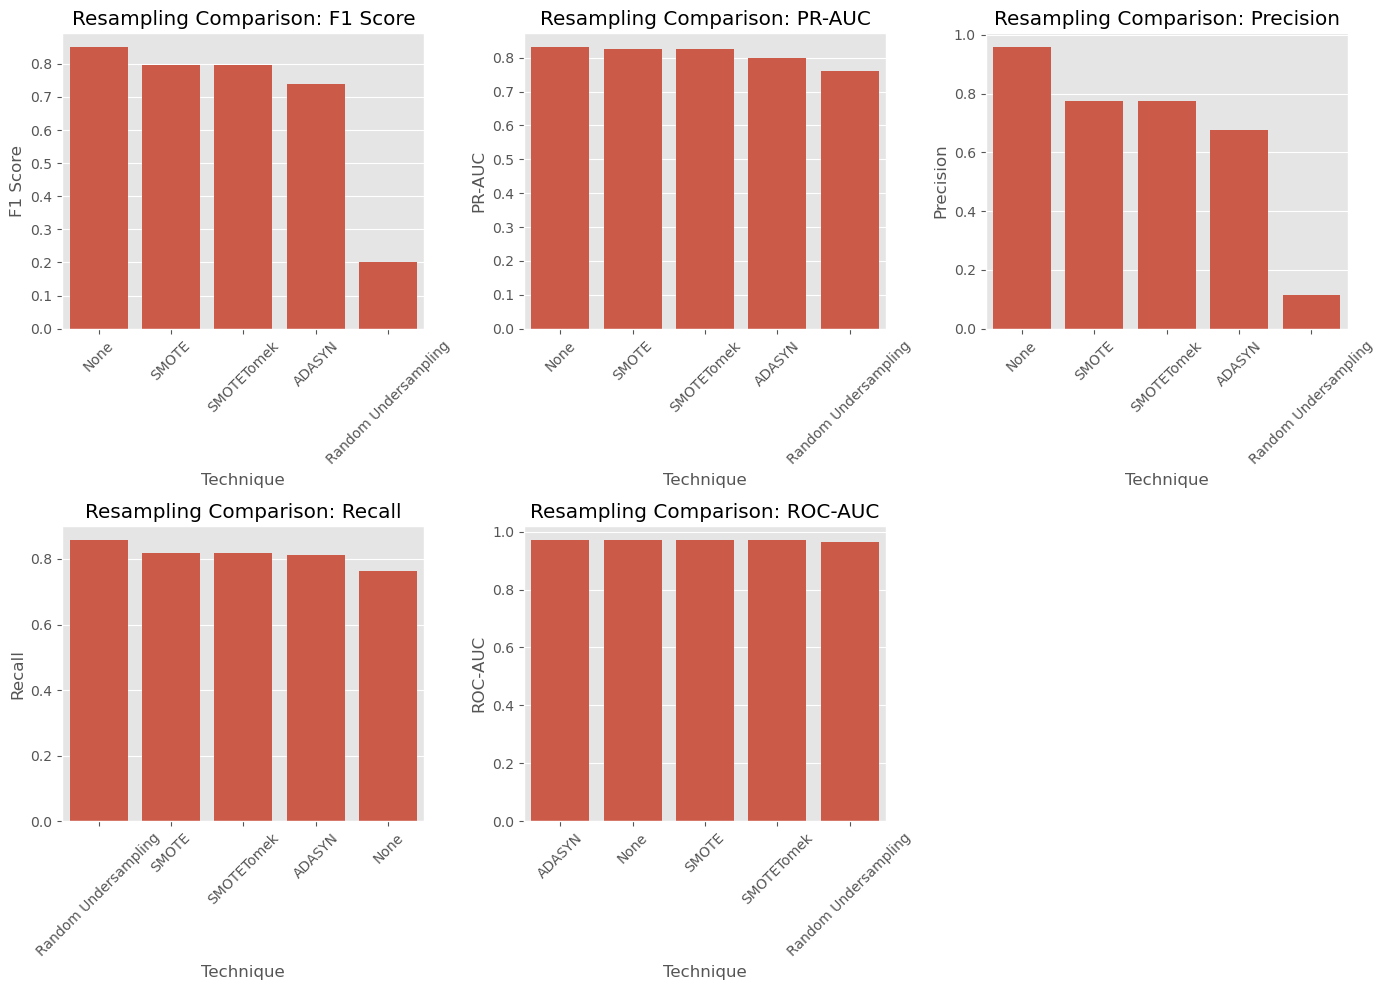


Best resampling technique: None with PR-AUC of 0.8304


In [ ]:

# === Define resampling techniques ===
print("\n=== EVALUATING RESAMPLING TECHNIQUES ===")

resampling_techniques = {
    'None': None,
    'SMOTE': SMOTE(sampling_strategy=0.1, random_state=42),  
    'ADASYN': ADASYN(sampling_strategy=0.1, random_state=42),
    'SMOTETomek': SMOTETomek(sampling_strategy=0.1, random_state=42),
    'Random Undersampling': RandomUnderSampler(sampling_strategy=0.5, random_state=42)
}

def evaluate_resampler(name, resampler, X_train, y_train, X_test, y_test):
    """Evaluate different resampling techniques"""
    print(f"\nEvaluating: {name}")
    
   
    if resampler is not None:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
        unique, counts = np.unique(y_res, return_counts=True)
        print(f"Class distribution after resampling: {dict(zip(unique, counts))}")
        print(f"Ratio (Fraud/Normal): {counts[1]/counts[0]:.4f}")
    else:
        X_res, y_res = X_train, y_train
        unique, counts = np.unique(y_res, return_counts=True)
        print(f"Original class distribution: {dict(zip(unique, counts))}")
        print(f"Ratio (Fraud/Normal): {counts[1]/counts[0]:.4f}")

    # Train a quick model to evaluate
    clf = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        random_state=42,
        n_jobs=4,
        early_stopping_rounds=10
    )

    # Split into train/validation
    X_res_train, X_res_val, y_res_train, y_res_val = train_test_split(
        X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
    )

    # Training model
    clf.fit(
        X_res_train, y_res_train,
        eval_set=[(X_res_val, y_res_val)],
        verbose=0
    )

    # Evaluate on test set
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Test metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}, ROC-AUC: {roc_auc:.4f}")

    # Garbage collection
    del clf, X_res_train, X_res_val, y_res_train, y_res_val
    gc.collect()

    return name, (f1, pr_auc, precision, recall, roc_auc), (X_res, y_res)



resampling_results = {}
resampled_data = {}

for name, resampler in resampling_techniques.items():
    name, metrics, data = evaluate_resampler(
        name, resampler, X_train_with_pca, y_train, X_test_with_pca, y_test
    )
    resampling_results[name] = metrics
    resampled_data[name] = data

# === Create results DataFrame ===
resampling_df = pd.DataFrame(columns=['Technique', 'F1 Score', 'PR-AUC', 'Precision', 'Recall', 'ROC-AUC'])

for name, metrics in resampling_results.items():
    resampling_df = pd.concat([resampling_df, pd.DataFrame({
        'Technique': [name],
        'F1 Score': [metrics[0]],
        'PR-AUC': [metrics[1]],
        'Precision': [metrics[2]],
        'Recall': [metrics[3]],
        'ROC-AUC': [metrics[4]]
    })], ignore_index=True)


print("\n=== RESAMPLING TECHNIQUES COMPARISON ===")
print(resampling_df.sort_values('PR-AUC', ascending=False))

plt.figure(figsize=(14, 10))
metrics_to_plot = ['F1 Score', 'PR-AUC', 'Precision', 'Recall', 'ROC-AUC']
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='Technique', y=metric, data=resampling_df.sort_values(metric, ascending=False))
    plt.title(f'Resampling Comparison: {metric}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('resampling_comparison.png')
plt.show()

# === Select best method by PR-AUC ===
best_resampling = resampling_df.loc[resampling_df['PR-AUC'].idxmax(), 'Technique']
print(f"\nBest resampling technique: {best_resampling} with PR-AUC of {resampling_df['PR-AUC'].max():.4f}")

# Get resampled data for best technique
X_train_resampled, y_train_resampled = resampled_data[best_resampling]


 MODEL TUNING & OPTIMIZATION-

 Models Optimized: XGBoost, LightGBM, and CatBoost.

Objective: Maximizing PR-AUC (Precision-Recall AUC) for each model.

Trials: 35 trials per model to optimize hyperparameters efficiently.

XGBoost: Optimizes parameters like max_depth, learning_rate, min_child_weight, subsample, etc., using cross-validation and early stopping.

LightGBM: Focuses on parameters such as num_leaves, learning_rate, max_depth, subsample, etc.

CatBoost: Tunes parameters like iterations, depth, learning_rate, l2_leaf_reg, etc.



In [ ]:

print("\n=== STARTING MODEL OPTIMIZATION ===")

# Force conversion to numpy arrays before optimization
def prepare_data(X, y):
    """Convert data to numpy arrays to avoid indexing issues"""
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X = X.values
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y = y.values
    return X, y


n_trials = 35  

def objective_xgb(trial):
    """Objective function for XGBoost optimization using lower-level XGBoost API"""
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 20.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'seed': 42
    }
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    
    try:
        # Get data as numpy arrays
        X_data, y_data = prepare_data(X_train_resampled, y_train_resampled)
        
        #  3 fold Cross-validation
        scores = []
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        for train_index, val_index in kf.split(X_data, y_data):
            X_t, X_v = X_data[train_index], X_data[val_index]
            y_t, y_v = y_data[train_index], y_data[val_index]
            
            try:
                dtrain = xgb.DMatrix(X_t, label=y_t)
                dval = xgb.DMatrix(X_v, label=y_v)
                
                # Train model with early stopping
                model = xgb.train(
                    param,
                    dtrain,
                    num_boost_round=n_estimators,
                    evals=[(dval, 'validation')],
                    early_stopping_rounds=10,
                    verbose_eval=False
                )
                
                # making predictions
                y_pred = model.predict(dval)
                score = average_precision_score(y_v, y_pred)
                scores.append(score)
            except Exception as e:
                print(f"Error during XGBoost training fold: {e}")
                continue
        
        if not scores:
            return 0.0
        
        return np.mean(scores)
    except Exception as e:
        print(f"Error in XGBoost objective function: {e}")
        return 0.0

def objective_lgbm(trial):
    """Objective function for LightGBM optimization"""
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 0.1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': 4,
        'verbose': -1
    }
    
    try:
        # Get data as numpy arrays to avoid indexing issues
        X_data, y_data = prepare_data(X_train_resampled, y_train_resampled)
        
        # 3 fold cross validation
        scores = []
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        for train_index, val_index in kf.split(X_data, y_data):
            X_t, X_v = X_data[train_index], X_data[val_index]
            y_t, y_v = y_data[train_index], y_data[val_index]
            
            try:
                model = LGBMClassifier(**param)
                model.fit(
                    X_t, y_t,
                    eval_set=[(X_v, y_v)],
                    eval_metric='auc',  
                    callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
                )
                
                y_pred = model.predict_proba(X_v)[:, 1]
                score = average_precision_score(y_v, y_pred)
                scores.append(score)
            except Exception as e:
                print(f"Error during LightGBM training fold: {e}")
                continue
        
        if not scores:
            return 0.0  
        
        # Return the average score
        return np.mean(scores)
    except Exception as e:
        print(f"Error in LightGBM objective function: {e}")
        return 0.0

def objective_catboost(trial):
    """Objective function for CatBoost optimization"""
    param = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 9),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 20.0),
        'random_seed': 42,
        'thread_count': 4,
        'verbose': 0
    }
    
    try:
        # Get data as numpy arrays to avoid indexing issues
        X_data, y_data = prepare_data(X_train_resampled, y_train_resampled)
        
        # 3 fold cross validation
        scores = []
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        for train_index, val_index in kf.split(X_data, y_data):
            X_t, X_v = X_data[train_index], X_data[val_index]
            y_t, y_v = y_data[train_index], y_data[val_index]
            
            try:
                model = CatBoostClassifier(**param)
                model.fit(
                    X_t, y_t,
                    eval_set=[(X_v, y_v)],
                    early_stopping_rounds=10,
                    verbose=0
                )
                
                y_pred = model.predict_proba(X_v)[:, 1]
                score = average_precision_score(y_v, y_pred)
                scores.append(score)
            except Exception as e:
                print(f"Error during CatBoost training fold: {e}")
                continue
        
        if not scores:
            return 0.0  
        

        return np.mean(scores)
    except Exception as e:
        print(f"Error in CatBoost objective function: {e}")
        return 0.0


try:
    X_train_resampled_shape = X_train_resampled.shape
    y_train_resampled_shape = y_train_resampled.shape
    print(f"Data loaded successfully. X shape: {X_train_resampled_shape}, y shape: {y_train_resampled_shape}")
except NameError:
    print("\nERROR: X_train_resampled and/or y_train_resampled not found.")
    print("Please define these variables before running the optimization.")
    print("Exiting...")
    sys.exit(1)

# Using Optuna for hyperparameter optimization
print("\nOptimizing XGBoost hyperparameters...")
study_xgb = optuna.create_study(direction='maximize', 
                              pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_xgb.optimize(objective_xgb, n_trials=n_trials)

print("\nOptimizing LightGBM hyperparameters...")
study_lgbm = optuna.create_study(direction='maximize',
                               pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_lgbm.optimize(objective_lgbm, n_trials=n_trials)

print("\nOptimizing CatBoost hyperparameters...")
study_catboost = optuna.create_study(direction='maximize',
                                   pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_catboost.optimize(objective_catboost, n_trials=n_trials)

# Displaying best parameters
print("\n=== BEST HYPERPARAMETERS ===")
print("Best XGBoost parameters:", study_xgb.best_params)
print("Best XGBoost PR-AUC:", study_xgb.best_value)

print("\nBest LightGBM parameters:", study_lgbm.best_params)
print("Best LightGBM PR-AUC:", study_lgbm.best_value)

print("\nBest CatBoost parameters:", study_catboost.best_params)
print("Best CatBoost PR-AUC:", study_catboost.best_value)

[I 2025-05-01 04:26:26,527] A new study created in memory with name: no-name-2ebb20c5-4a9e-466b-99da-33cf96c323fe



=== STARTING MODEL OPTIMIZATION ===
Data loaded successfully. X shape: (199364, 82), y shape: (199364,)

Optimizing XGBoost hyperparameters...


[I 2025-05-01 04:26:29,257] Trial 0 finished with value: 0.7994063621552564 and parameters: {'max_depth': 8, 'learning_rate': 0.05683428610878098, 'min_child_weight': 8, 'subsample': 0.9640574859112433, 'colsample_bytree': 0.658049626028408, 'scale_pos_weight': 14.702994805296372, 'gamma': 3.233054833067695, 'reg_alpha': 1.3064967197331423, 'reg_lambda': 4.711382078954048, 'n_estimators': 125}. Best is trial 0 with value: 0.7994063621552564.
[I 2025-05-01 04:26:32,693] Trial 1 finished with value: 0.8550320733869584 and parameters: {'max_depth': 9, 'learning_rate': 0.12277515554388148, 'min_child_weight': 1, 'subsample': 0.8267389864881388, 'colsample_bytree': 0.6672458103578106, 'scale_pos_weight': 9.877678313181661, 'gamma': 2.5619191104596424, 'reg_alpha': 2.6420552170685943, 'reg_lambda': 0.3603271896693433, 'n_estimators': 186}. Best is trial 1 with value: 0.8550320733869584.
[I 2025-05-01 04:26:34,035] Trial 2 finished with value: 0.7816818193568852 and parameters: {'max_depth': 


Optimizing LightGBM hyperparameters...


[I 2025-05-01 04:27:51,544] Trial 0 finished with value: 0.619820443950776 and parameters: {'n_estimators': 172, 'learning_rate': 0.04188174414270838, 'num_leaves': 15, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.7577488949340045, 'colsample_bytree': 0.8472066419205526, 'min_split_gain': 0.0654614371532401, 'min_child_weight': 0.05758877155203755, 'reg_alpha': 0.6656690953733945, 'reg_lambda': 0.3119968521977152}. Best is trial 0 with value: 0.619820443950776.
[I 2025-05-01 04:27:53,568] Trial 1 finished with value: 0.7574663700127037 and parameters: {'n_estimators': 122, 'learning_rate': 0.05317034633932295, 'num_leaves': 39, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.987240130420041, 'colsample_bytree': 0.7078863219212104, 'min_split_gain': 0.07908346268468336, 'min_child_weight': 0.023090788536899096, 'reg_alpha': 0.7726874816595363, 'reg_lambda': 0.5701381361683314}. Best is trial 1 with value: 0.7574663700127037.
[I 2025-05-01 04:27:55,775] Trial 2 finishe


Optimizing CatBoost hyperparameters...


[I 2025-05-01 04:29:23,937] Trial 0 finished with value: 0.8544470484655932 and parameters: {'iterations': 260, 'learning_rate': 0.016424637191038035, 'depth': 9, 'l2_leaf_reg': 3.868062400764211, 'border_count': 50, 'scale_pos_weight': 7.829619352683353}. Best is trial 0 with value: 0.8544470484655932.
[I 2025-05-01 04:29:39,741] Trial 1 finished with value: 0.8254502674138392 and parameters: {'iterations': 248, 'learning_rate': 0.03416364735621317, 'depth': 6, 'l2_leaf_reg': 5.096850242541529, 'border_count': 36, 'scale_pos_weight': 17.66153006761936}. Best is trial 0 with value: 0.8544470484655932.
[I 2025-05-01 04:29:54,761] Trial 2 finished with value: 0.8437288358535372 and parameters: {'iterations': 88, 'learning_rate': 0.06227901174803123, 'depth': 5, 'l2_leaf_reg': 9.27600851932965, 'border_count': 50, 'scale_pos_weight': 4.318186315058683}. Best is trial 0 with value: 0.8544470484655932.
[I 2025-05-01 04:30:09,249] Trial 3 finished with value: 0.8319051245581246 and parameter


=== BEST HYPERPARAMETERS ===
Best XGBoost parameters: {'max_depth': 7, 'learning_rate': 0.18494416071542705, 'min_child_weight': 2, 'subsample': 0.8127280281833568, 'colsample_bytree': 0.8984609339344488, 'scale_pos_weight': 2.9646884379728697, 'gamma': 0.625433414055151, 'reg_alpha': 1.5350490406295043, 'reg_lambda': 2.9792649367204804, 'n_estimators': 154}
Best XGBoost PR-AUC: 0.8606248779639722

Best LightGBM parameters: {'n_estimators': 202, 'learning_rate': 0.046615957242020854, 'num_leaves': 52, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.8017751994427176, 'colsample_bytree': 0.6007502466458627, 'min_split_gain': 0.0760983281560151, 'min_child_weight': 0.01689099879581873, 'reg_alpha': 0.24146454018209118, 'reg_lambda': 0.9686097081672093}
Best LightGBM PR-AUC: 0.7684928970389158

Best CatBoost parameters: {'iterations': 297, 'learning_rate': 0.03009587480232146, 'depth': 7, 'l2_leaf_reg': 4.353499024549605, 'border_count': 52, 'scale_pos_weight': 1.0996478591041439}

 TRAINING FINAL MODELS

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb

print("\n=== TRAINING FINAL MODELS ===")

# Creating validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled
)

#  XGBoost 
xgb_params = study_xgb.best_params.copy()
n_estimators_xgb = xgb_params.pop('n_estimators', 300)

xgb_model = XGBClassifier(n_estimators=n_estimators_xgb, **xgb_params, n_jobs=4)
xgb_model.fit(X_train_final, y_train_final)

#  LightGBM 
lgbm_params = study_lgbm.best_params.copy()
n_estimators_lgbm = lgbm_params.pop('n_estimators', 300)
lgbm_model = LGBMClassifier(n_estimators=n_estimators_lgbm, **lgbm_params, n_jobs=4)
lgbm_model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
)

#  CatBoost 
catboost_params = study_catboost.best_params.copy()
iterations = catboost_params.pop('iterations', 300)
catboost_model = CatBoostClassifier(iterations=iterations, **catboost_params, thread_count=4)
catboost_model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=0
)



=== TRAINING FINAL MODELS ===


MODEL EVALUATION

find_optimal_threshold: Finds the threshold that maximizes the F1 score using the precision-recall curve.

evaluate_model: Evaluates the model using several metrics including ROC AUC, PR AUC, Precision, Recall, F1 score, and confusion matrix.

XGBoost: Evaluated using the test data (X_test_with_pca, y_test), output includes metrics like ROC AUC, PR AUC, Precision, Recall, F1 score, and confusion matrix.

LightGBM: Same evaluation process as XGBoost.

CatBoost: Same evaluation process as XGBoost.

Ensemble Creation: A weighted average of model predictions (XGBoost, LightGBM, CatBoost) based on their validation PR AUC scores.

Ensemble Weights: Calculated based on validation PR AUC

Ensemble Metrics: The weighted ensemble is evaluated using the same metrics as individual models, including ROC AUC, PR AUC, Precision, Recall, F1 score, and confusion matrix.

Optimal Threshold for Ensemble: Calculated using the F1 score.

Ensemble Results: Printed for evaluation

In [ ]:
print("\n=== EVALUATING MODELS ===")

# Function to find optimal threshold using F1 score
def find_optimal_threshold(y_true, y_score):
    """Find the optimal threshold that maximizes F1 score"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)

    f1_scores = 2 * precision * recall / (precision + recall + 1e-7)
    if len(thresholds) < len(f1_scores):
        thresholds = np.append(thresholds, 1.0)
    return thresholds[np.argmax(f1_scores)], np.max(f1_scores)

# Function to evaluate and visualize model performance
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return predictions and metrics"""
    y_prob = model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    
    # Finding optimal threshold
    optimal_threshold, best_f1 = find_optimal_threshold(y_test, y_prob)
    y_pred = (y_prob >= optimal_threshold).astype(int)
    
    # Calculation of  metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{model_name} Model Evaluation:")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    

    cm = confusion_matrix(y_test, y_pred)
    
    # Return results
    return {
        'model_name': model_name,
        'y_prob': y_prob,
        'y_pred': y_pred,
        'optimal_threshold': optimal_threshold,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Evaluating  each model
xgb_results = evaluate_model(xgb_model, X_test_with_pca, y_test, "XGBoost")
lgbm_results = evaluate_model(lgbm_model, X_test_with_pca, y_test, "LightGBM")
catboost_results = evaluate_model(catboost_model, X_test_with_pca, y_test, "CatBoost")


# Calculating weights based on validation PR-AUC
xgb_val_probs = xgb_model.predict_proba(X_val)[:, 1]
lgbm_val_probs = lgbm_model.predict_proba(X_val)[:, 1]
catboost_val_probs = catboost_model.predict_proba(X_val)[:, 1]

xgb_val_pr_auc = average_precision_score(y_val, xgb_val_probs)
lgbm_val_pr_auc = average_precision_score(y_val, lgbm_val_probs)
catboost_val_pr_auc = average_precision_score(y_val, catboost_val_probs)

# Calculating weighted ensemble weights based on PR-AUC
total_pr_auc = xgb_val_pr_auc + lgbm_val_pr_auc + catboost_val_pr_auc
weights = [
    xgb_val_pr_auc / total_pr_auc,
    lgbm_val_pr_auc / total_pr_auc,
    catboost_val_pr_auc / total_pr_auc
]

print(f"\nEnsemble weights:")
print(f"XGBoost: {weights[0]:.4f}")
print(f"LightGBM: {weights[1]:.4f}")
print(f"CatBoost: {weights[2]:.4f}")

# Creating ensemble predictions
ensemble_probs = (
    weights[0] * xgb_results['y_prob'] + 
    weights[1] * lgbm_results['y_prob'] + 
    weights[2] * catboost_results['y_prob']
)

# Evaluating ensemble
ensemble_results = {
    'model_name': 'Weighted Ensemble',
    'y_prob': ensemble_probs
}

# Finding optimal threshold for ensemble
optimal_threshold, _ = find_optimal_threshold(y_test, ensemble_probs)
ensemble_results['optimal_threshold'] = optimal_threshold
ensemble_results['y_pred'] = (ensemble_probs >= optimal_threshold).astype(int)

# Calculating metrics for ensemble
ensemble_results['roc_auc'] = roc_auc_score(y_test, ensemble_probs)
ensemble_results['pr_auc'] = average_precision_score(y_test, ensemble_probs)
ensemble_results['precision'] = precision_score(y_test, ensemble_results['y_pred'])
ensemble_results['recall'] = recall_score(y_test, ensemble_results['y_pred'])
ensemble_results['f1'] = f1_score(y_test, ensemble_results['y_pred'])
ensemble_results['confusion_matrix'] = confusion_matrix(y_test, ensemble_results['y_pred'])

print(f"\nWeighted Ensemble Model Evaluation:")
print(f"ROC AUC: {ensemble_results['roc_auc']:.4f}")
print(f"PR AUC: {ensemble_results['pr_auc']:.4f}")
print(f"Optimal threshold: {ensemble_results['optimal_threshold']:.4f}")
print(f"Precision: {ensemble_results['precision']:.4f}")
print(f"Recall: {ensemble_results['recall']:.4f}")
print(f"F1 Score: {ensemble_results['f1']:.4f}")


=== EVALUATING MODELS ===

XGBoost Model Evaluation:
ROC AUC: 0.9730
PR AUC: 0.8334
Optimal threshold: 0.4361
Precision: 0.9225
Recall: 0.8041
F1 Score: 0.8592

LightGBM Model Evaluation:
ROC AUC: 0.9557
PR AUC: 0.8028
Optimal threshold: 0.4689
Precision: 0.9153
Recall: 0.7297
F1 Score: 0.8120

CatBoost Model Evaluation:
ROC AUC: 0.9792
PR AUC: 0.8235
Optimal threshold: 0.2989
Precision: 0.9141
Recall: 0.7905
F1 Score: 0.8478

Ensemble weights:
XGBoost: 0.3374
LightGBM: 0.3275
CatBoost: 0.3351

Weighted Ensemble Model Evaluation:
ROC AUC: 0.9768
PR AUC: 0.8294
Optimal threshold: 0.3943
Precision: 0.9280
Recall: 0.7838
F1 Score: 0.8498


VISUALISATIONS AND REPORTING


=== GENERATING VISUALIZATIONS ===

=== MODEL PERFORMANCE COMPARISON ===


,Model,ROC-AUC,PR-AUC,Precision,Recall,F1 Score,Threshold
0,XGBoost,0.9730,0.8334,0.9225,0.8041,0.8592,0.4361
3,Weighted Ensemble,0.9768,0.8294,0.9280,0.7838,0.8498,0.3943
2,CatBoost,0.9792,0.8235,0.9141,0.7905,0.8478,0.2989
1,LightGBM,0.9557,0.8028,0.9153,0.7297,0.8120,0.4689


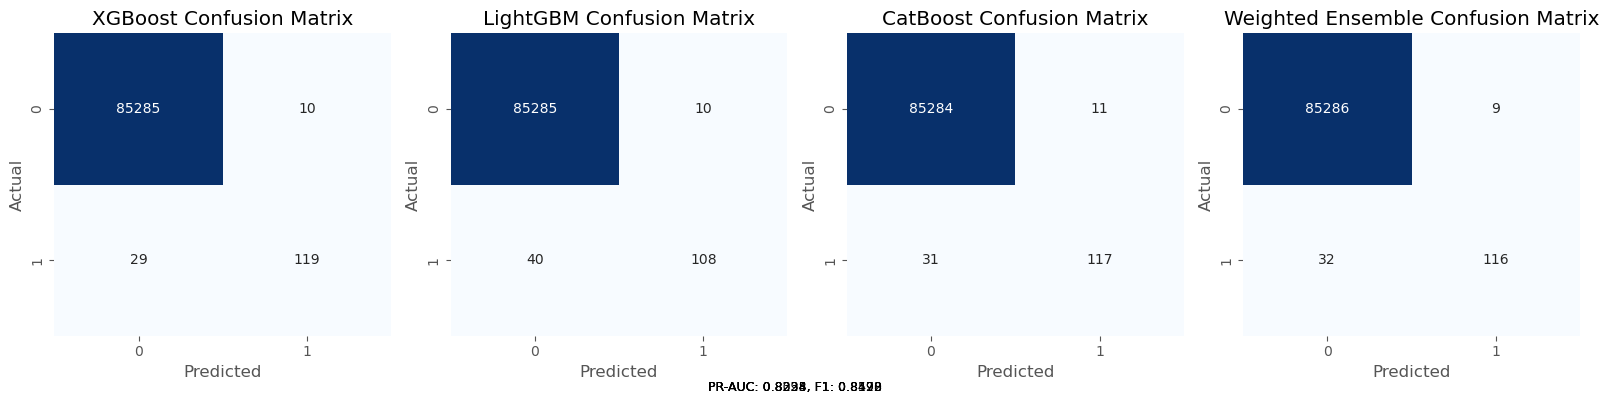

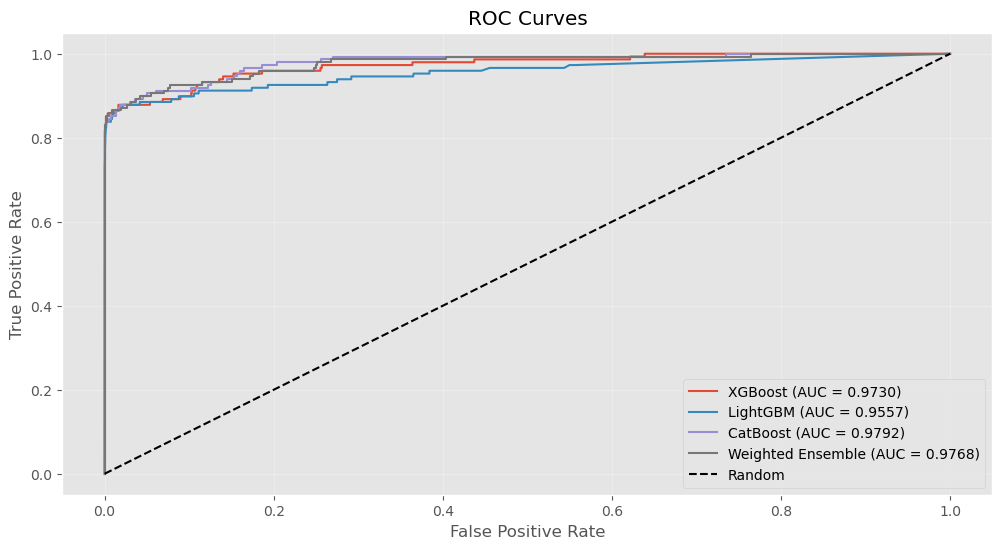

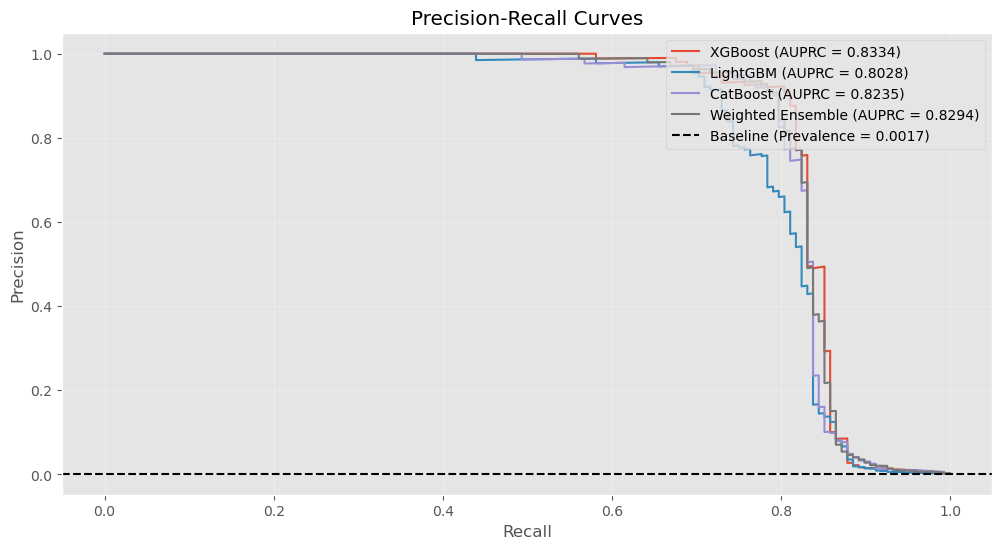

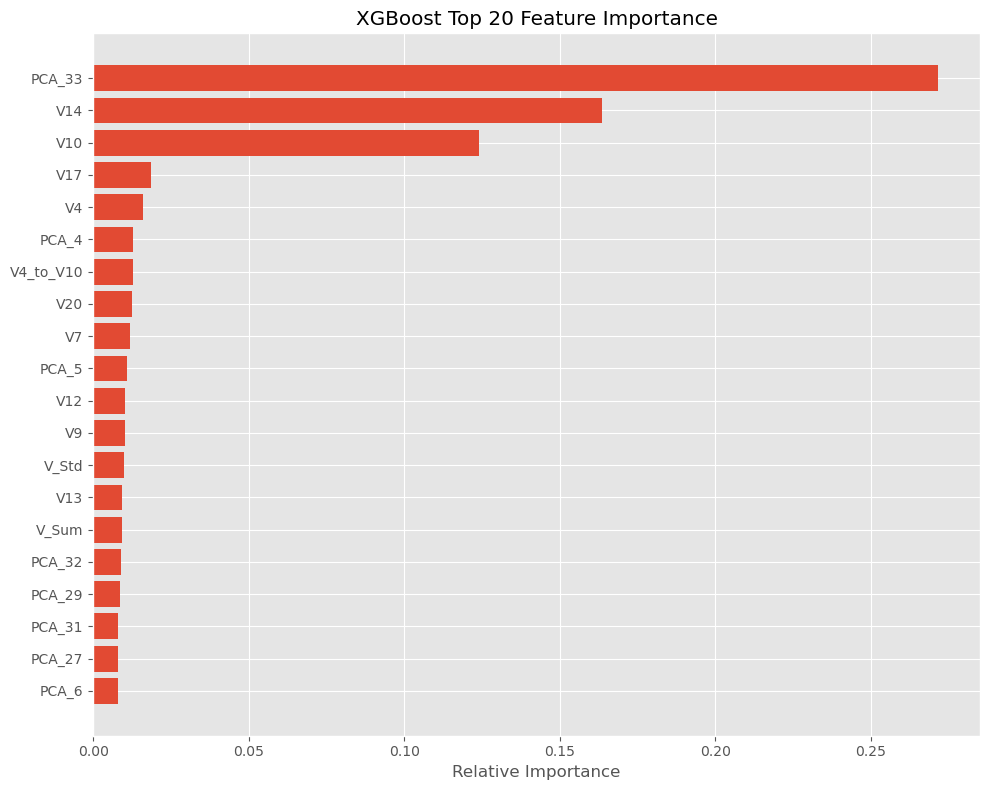

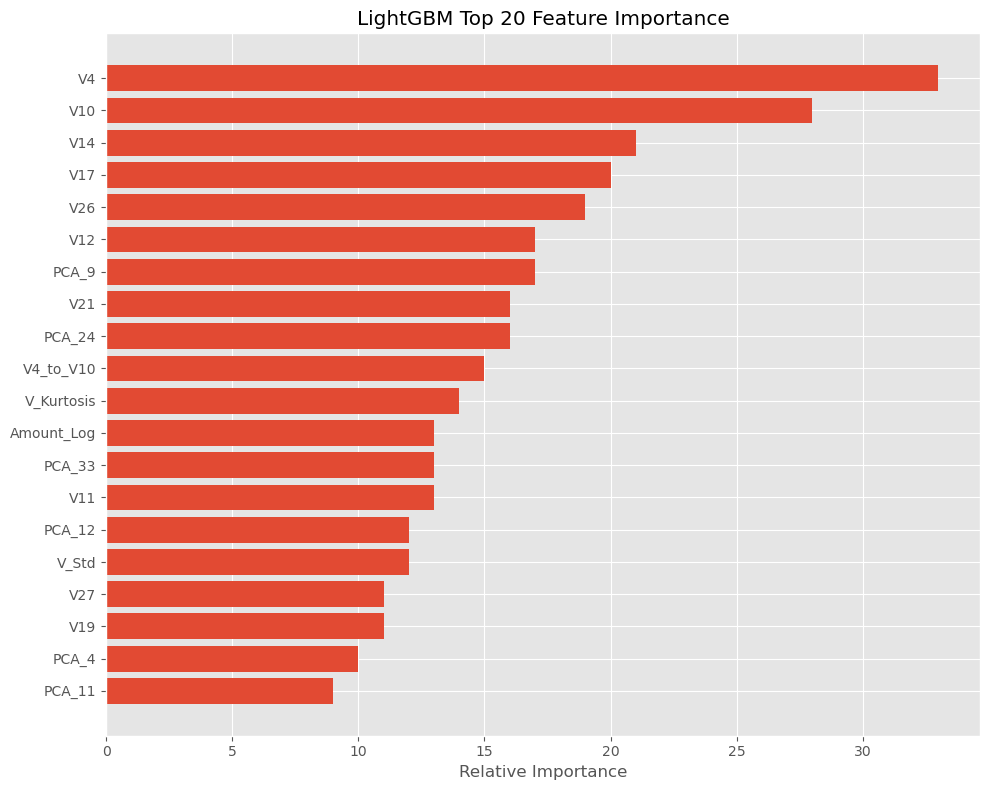

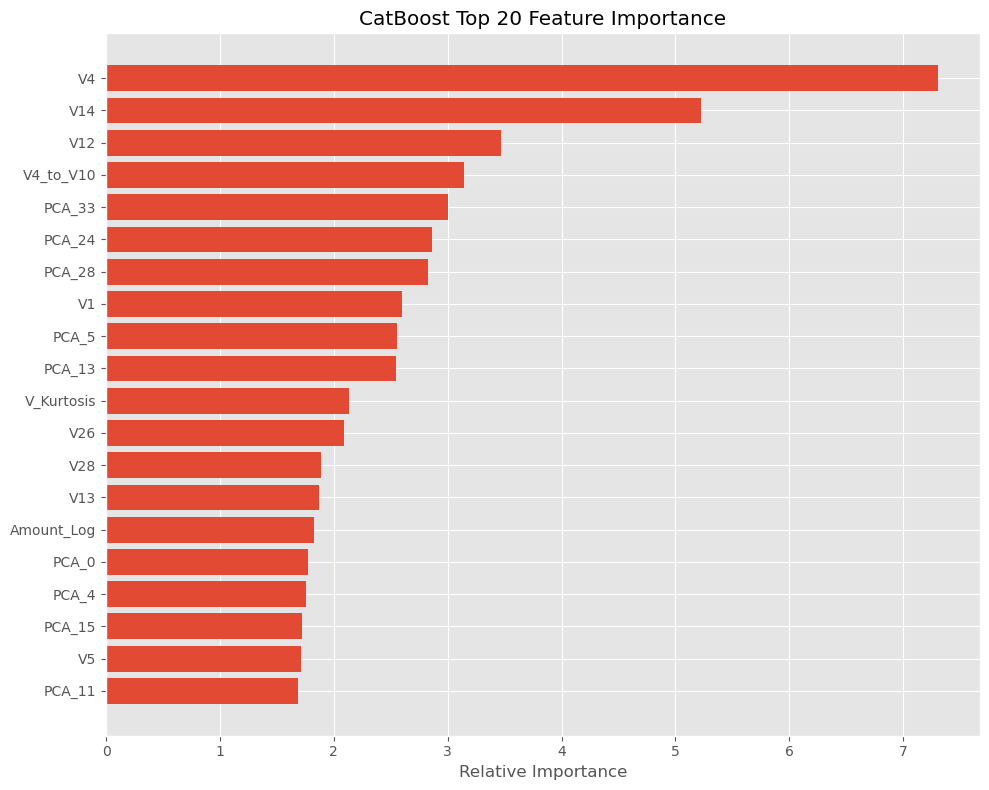

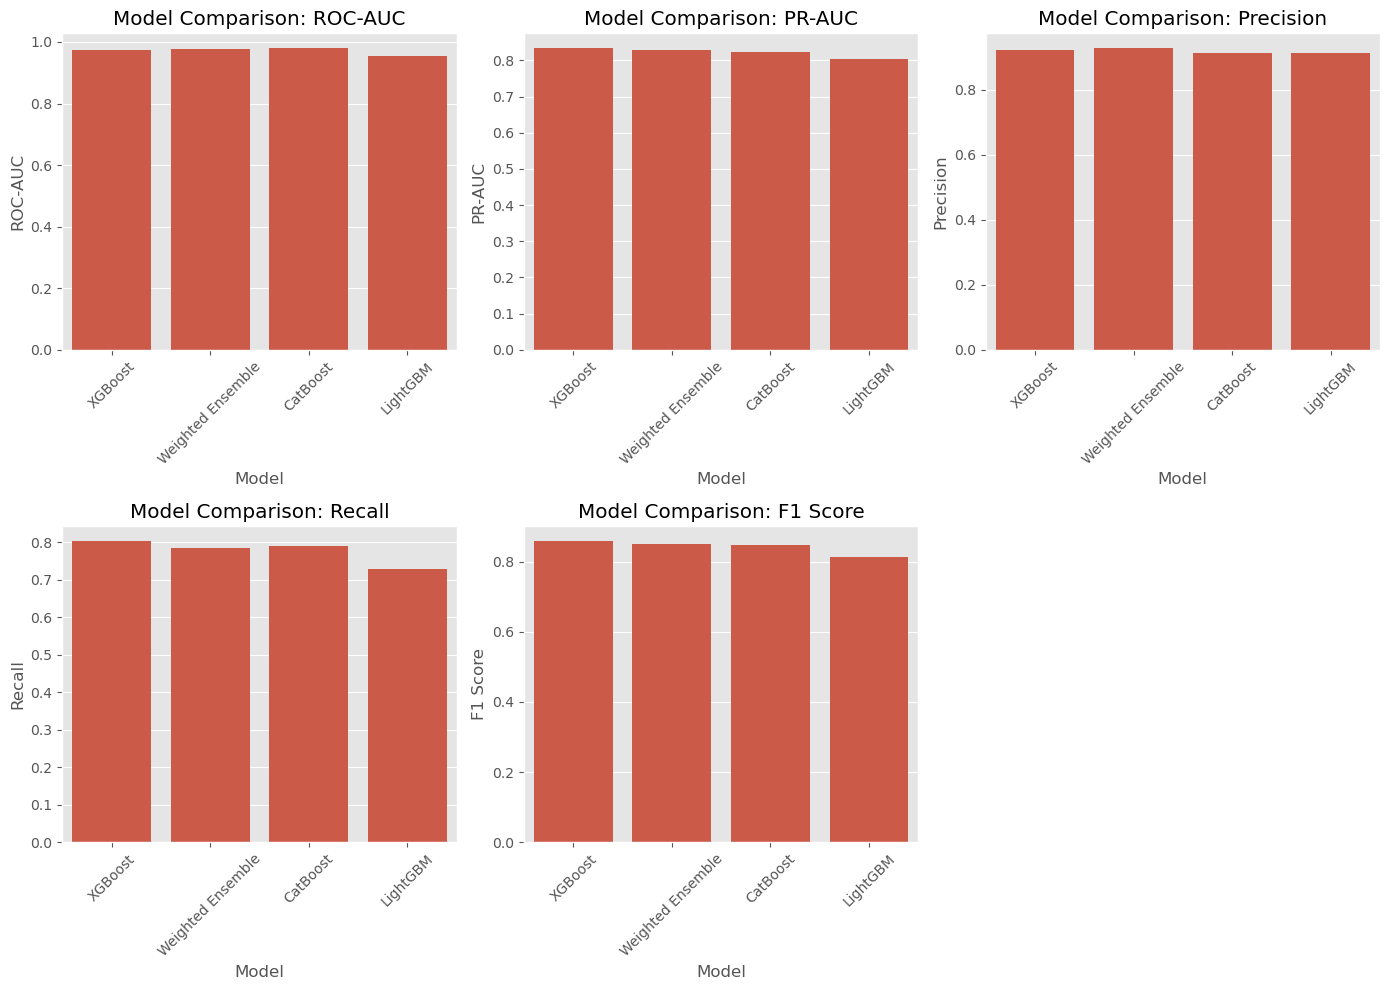

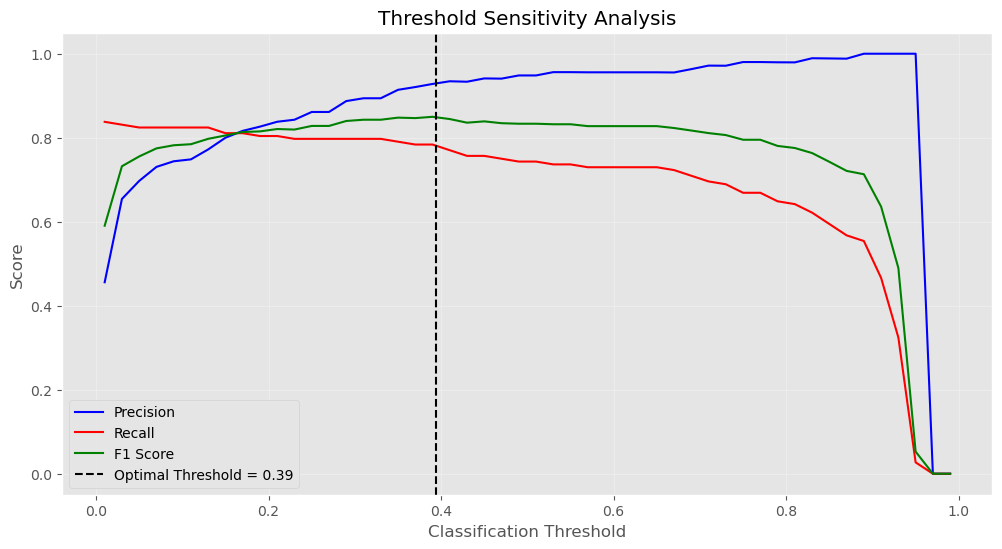

In [ ]:
print("\n=== GENERATING VISUALIZATIONS ===")

# 1. Model Comparison Table
results_df = pd.DataFrame({
    'Model': [res['model_name'] for res in [xgb_results, lgbm_results, catboost_results, ensemble_results]],
    'ROC-AUC': [res['roc_auc'] for res in [xgb_results, lgbm_results, catboost_results, ensemble_results]],
    'PR-AUC': [res['pr_auc'] for res in [xgb_results, lgbm_results, catboost_results, ensemble_results]],
    'Precision': [res['precision'] for res in [xgb_results, lgbm_results, catboost_results, ensemble_results]],
    'Recall': [res['recall'] for res in [xgb_results, lgbm_results, catboost_results, ensemble_results]],
    'F1 Score': [res['f1'] for res in [xgb_results, lgbm_results, catboost_results, ensemble_results]],
    'Threshold': [res['optimal_threshold'] for res in [xgb_results, lgbm_results, catboost_results, ensemble_results]]
})

# Sort by PR-AUC (most relevant for imbalanced classification)
results_df = results_df.sort_values('PR-AUC', ascending=False)

print("\n=== MODEL PERFORMANCE COMPARISON ===")
display(results_df.style.format({
    'ROC-AUC': '{:.4f}',
    'PR-AUC': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}',
    'Threshold': '{:.4f}'
}).background_gradient(cmap='YlGnBu', subset=['PR-AUC', 'F1 Score']))

# Saving results to csv
results_df.to_csv('fraud_detection_model_comparison.csv', index=False)

# 2. Confusion Matrices
plt.figure(figsize=(16, 4))
models = [xgb_results, lgbm_results, catboost_results, ensemble_results]

for i, model_res in enumerate(models):
    plt.subplot(1, 4, i+1)
    cm = model_res['confusion_matrix']
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_res['model_name']} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Add metrics as text
    plt.figtext(0.5, 0.01, 
                f"PR-AUC: {model_res['pr_auc']:.4f}, F1: {model_res['f1']:.4f}", 
                ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

# 3. ROC Curves
plt.figure(figsize=(12, 6))

for model_res in models:
    fpr, tpr, _ = roc_curve(y_test, model_res['y_prob'])
    plt.plot(fpr, tpr, 
             label=f"{model_res['model_name']} (AUC = {model_res['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('roc_curves.png')
plt.show()

# 4. Precision-Recall Curves
plt.figure(figsize=(12, 6))

for model_res in models:
    precision, recall, _ = precision_recall_curve(y_test, model_res['y_prob'])
    plt.plot(recall, precision, 
             label=f"{model_res['model_name']} (AUPRC = {model_res['pr_auc']:.4f})")

plt.axhline(y=sum(y_test)/len(y_test), color='k', linestyle='--', 
           label=f'Baseline (Prevalence = {sum(y_test)/len(y_test):.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.savefig('pr_curves.png')
plt.show()

# 5. Feature Importance Plots
def plot_feature_importance(model, feature_names, model_name, top_n=20):
    """Plot feature importance for a given model"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        print(f"Model {model_name} doesn't have feature_importances_ attribute")
        return
    
    # Getting indices of top features
    indices = np.argsort(importances)[-top_n:]
    
    plt.figure(figsize=(10, 8))
    plt.title(f'{model_name} Top {top_n} Feature Importance')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(f'{model_name}_feature_importance.png')
    plt.show()

# Plotting feature importances
plot_feature_importance(xgb_model, all_feature_names, 'XGBoost')
plot_feature_importance(lgbm_model, all_feature_names, 'LightGBM')
plot_feature_importance(catboost_model, all_feature_names, 'CatBoost')

# 6. Model Performance Metrics Visualization
plt.figure(figsize=(14, 10))

metrics = ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Model Comparison: {metric}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_metrics_comparison.png')
plt.show()

# 7. Threshold Sensitivity Analysis
thresholds = np.linspace(0.01, 0.99, 50)
best_model_probs = ensemble_results['y_prob']  

precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred = (best_model_probs >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_scores, 'b-', label='Precision')
plt.plot(thresholds, recall_scores, 'r-', label='Recall')
plt.plot(thresholds, f1_scores, 'g-', label='F1 Score')

# Marking the optimal threshold
optimal_threshold = ensemble_results['optimal_threshold']
plt.axvline(x=optimal_threshold, color='k', linestyle='--', 
           label=f'Optimal Threshold = {optimal_threshold:.2f}')

plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Threshold Sensitivity Analysis')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig('threshold_sensitivity.png')
plt.show()


In [ ]:
print("\n=== SAVING THE BEST MODEL ===")

import pickle

# Identifying the best model based on PR-AUC
best_model_name = results_df.iloc[0]['Model']
print(f"Best model based on PR-AUC: {best_model_name}")

# Saving the corresponding model
best_model = None
if best_model_name == 'XGBoost':
    best_model = xgb_model
elif best_model_name == 'LightGBM':
    best_model = lgbm_model
elif best_model_name == 'CatBoost':
    best_model = catboost_model
elif best_model_name == 'Weighted Ensemble':
    # For ensemble, saving all component models and weights
    with open('ensemble_models.pkl', 'wb') as f:
        pickle.dump({
            'xgb_model': xgb_model,
            'lgbm_model': lgbm_model,
            'catboost_model': catboost_model,
            'weights': weights,
            'threshold': ensemble_results['optimal_threshold'],
            'feature_engineer': feature_engineer,
            'preprocess_pipeline': preprocess_pipeline,
            'pca': pca
        }, f)
    print("Ensemble model saved as 'ensemble_models.pkl'")
    best_model = 'ensemble'

# If a single model was best
if best_model != 'ensemble' and best_model is not None:
    with open(f'{best_model_name.lower()}_model.pkl', 'wb') as f:
        pickle.dump({
            'model': best_model,
            'threshold': results_df.iloc[0]['Threshold'],
            'feature_engineer': feature_engineer,
            'preprocess_pipeline': preprocess_pipeline,
            'pca': pca
        }, f)
    print(f"{best_model_name} model saved as '{best_model_name.lower()}_model.pkl'")



=== SAVING THE BEST MODEL ===
Best model based on PR-AUC: XGBoost
XGBoost model saved as 'xgboost_model.pkl'


 FRAUD DETECTION MODEL SUMMARY 

In [ ]:

print("\n FRAUD DETECTION MODEL SUMMARY ")
print(f"Training Data: {X_train.shape[0]} samples")
print(f"Test Data: {X_test.shape[0]} samples")
print(f"Fraud Rate: {y.mean()*100:.4f}%")
print(f"Best Resampling Technique: {best_resampling}")
print(f"Best Model: {best_model_name}")
print(f"Best PR-AUC: {results_df.iloc[0]['PR-AUC']:.4f}")
print(f"Best F1 Score: {results_df.iloc[0]['F1 Score']:.4f}")
print(f"Optimal Threshold: {results_df.iloc[0]['Threshold']:.4f}")

# Calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Total execution time: {int(hours):02d}:{int(minutes):02d}:{seconds:.2f}")

print("\nModel successfully trained and evaluated!")

# Cleaning up cache directory
import shutil
if 'cachedir' in locals():
    shutil.rmtree(cachedir)


=== FRAUD DETECTION MODEL SUMMARY ===
Training Data: 199364 samples
Test Data: 85443 samples
Fraud Rate: 0.1727%
Best Resampling Technique: None
Best Model: XGBoost
Best PR-AUC: 0.8334
Best F1 Score: 0.8592
Optimal Threshold: 0.4361
Total execution time: 00:14:52.71

Model successfully trained and evaluated!
